In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import dask
import gev_bayes_utils as gevbu
import gev_utils as gevu
import sa_city_utils as scu

from utils import city_list, gev_metric_ids
from utils import roar_data_path as project_data_path
from utils import roar_code_path as project_code_path

In [2]:
# ############
# ### Dask ###
# ############
# from dask_jobqueue import SLURMCluster

# cluster = SLURMCluster(
#     # account="pches",
#     account="open",
#     cores=3,
#     processes=1,
#     job_cpu=3,
#     memory="3GiB",
#     walltime="12:00:00",
#     job_script_prologue=[
#         f"export PYTHONPATH={project_code_path}/.venv/lib/python3.12/site-packages:$PYTHONPATH",  # Put venv first
#         "export JAX_PLATFORM_NAME=cpu",
#         "export XLA_FLAGS='--xla_force_host_platform_device_count=1'",
#         # Force PyTensor to not use caching at all
#         "export PYTENSOR_FLAGS='cxx=,",
#         "mode=FAST_COMPILE,",  # Less aggressive optimization but more stable
#         "allow_gc=True,",
#         "cache_size=0'"        # Disable caching completely
#     ],
#     death_timeout=60,
#     local_directory="/tmp"
# )

# cluster.scale(5)

# from dask.distributed import Client
# client = Client(cluster)
# client

In [3]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    processes=1,
    job_cpu=1,
    memory="10GiB",
    walltime="01:00:00",
)

cluster.scale(30)

from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.8.59:44203,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Get city timeseries

In [4]:
# Run for all
for city in city_list.keys():
    for metric_id in gev_metric_ids:
        scu.get_city_timeseries_all(city, metric_id)
    for metric_id in trend_metric_ids:
        scu.get_city_timeseries_all(city, metric_id)

## Stationary GEV with bootstrap

In [4]:
stationary = True
fit_method = "lmom"
periods_for_level = [10,25,50,100]

# Loop through all
delayed = []

for city in city_list:
    for metric_id in gev_metric_ids:
        delayed.append(dask.delayed(gevu.fit_ensemble_gev_city)
                       (city=city,
                        metric_id=metric_id,
                        stationary=stationary,
                        fit_method=fit_method,
                        periods_for_level=periods_for_level)
                      )

_ = dask.compute(*delayed)

## Non-stationary GEV

In [ ]:
df = pd.read_csv('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/cities/')

In [3]:
%%time
gevu.fit_gev_city(
    city='nyc',
    metric_id='max_tasmax',
    ensemble='LOCA2',
    gcm='CanESM5',
    ssp='ssp585',
    member='r1i1p1f1',
    hist_slice=None,
    proj_slice=None,
    fit_method='mle',
    stationary=False,
    periods_for_level=[10,25,50,100],
    years=[1950,2100],
    bootstrap="parametric",
    return_period_years=[1975,2075],
    return_period_diffs=[[1975,2075]],
    n_boot=250
)

CPU times: user 34.3 s, sys: 27.6 ms, total: 34.3 s
Wall time: 35.9 s


,quantile,ensemble,gcm,member,ssp,loc_intcp,loc_trend,scale,shape,10yr_return_level_1975,...,25yr_return_level_1975,25yr_return_level_2075,50yr_return_level_1975,50yr_return_level_2075,100yr_return_level_1975,100yr_return_level_2075,10yr_return_level_2075-1975,25yr_return_level_2075-1975,50yr_return_level_2075-1975,100yr_return_level_2075-1975
0,main,LOCA2,CanESM5,r1i1p1f1,ssp585,33.171580,0.067416,1.429404,0.104638,37.723007,...,44.464639,44.464639,38.742559,38.742559,45.484191,45.484191,42.779231,43.798783,44.492405,45.132222
1,p025,LOCA2,CanESM5,r1i1p1f1,ssp585,32.782160,0.063007,1.225438,0.010916,37.225275,...,43.962142,43.962142,38.076811,38.076811,44.776479,44.776479,42.324678,43.090754,43.597748,44.040538
2,p975,LOCA2,CanESM5,r1i1p1f1,ssp585,33.622514,0.072488,1.566587,0.206294,38.236890,...,44.905216,44.905216,39.420018,39.420018,46.080483,46.080483,43.193785,44.391105,45.246234,46.145237


In [6]:
35*464/60/60

4.511111111111111

In [22]:
from scipy.stats import genextreme as gev

In [29]:
test = gev.rvs(-0.5, loc=np.arange(100), scale=20, size=(10, 100))

In [32]:
import matplotlib.pyplot as plt

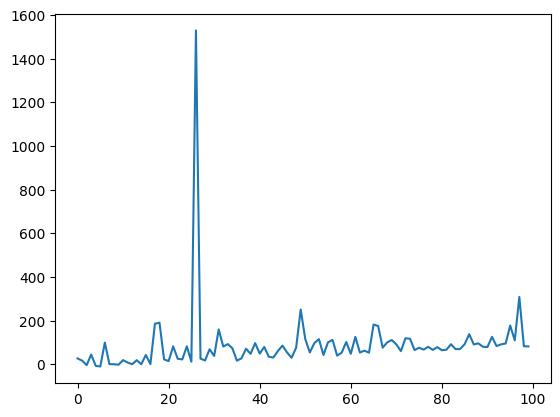

In [34]:
plt.plot(test[5])

In [8]:
df = pd.read_csv(f"{project_data_path}/metrics/cities/nyc_max_tasmax.csv")

In [19]:
464*6/60

46.4

In [15]:
df[df['ssp'] != 'historical'].groupby(['gcm', 'member', 'ssp', 'ensemble']).count()

time  tasmax
gcm        member   ssp    ensemble               
ACCESS-CM2 r1i1p1f1 ssp245 LOCA2        86      86
                           STAR-ESDM   151     151
                    ssp370 LOCA2        86      86
                    ssp585 LOCA2        86      86
                           STAR-ESDM   151     151
...                                    ...     ...
NorESM2-MM r2i1p1f1 ssp245 LOCA2        86      86
TaiESM1    r1i1p1f1 ssp245 LOCA2        86      86
                           STAR-ESDM   151     151
                    ssp370 LOCA2        86      86
                    ssp585 STAR-ESDM   151     151

[464 rows x 2 columns]

In [ ]:
100*

In [3]:
gevu.fit_ensemble_gev_city(city='nyc',
                            metric_id='max_tasmax',
                            years=[1950,2100],
                            stationary=False,
                            periods_for_level=[10,25,50,100],
                            fit_method='mle',
                           return_period_years=return_period_years,
                           return_period_diffs=return_period_diffs
                          )

ValueError: No objects to concatenate

In [8]:
years = [1950,2100]
stationary = False
fit_method = "mle"
periods_for_level = [10,25,50,100]
return_period_years = [1975, 2075]
return_period_diffs = [[1975,2075]]

# Loop through all
with warnings.catch_warnings(action="ignore"):
    for city in city_list:
        for metric_id in gev_metric_ids:
            delayed.append(dask.delayed(gevu.fit_ensemble_gev_city)
                           (city=city,
                            metric_id=metric_id,
                            years=years,
                            stationary=stationary,
                            periods_for_level=periods_for_level,
                            fit_method=fit_method,
                           return_period_years=return_period_years,
                           return_period_diffs=return_period_diffs)
                          )
            
_ = dask.compute(*delayed)

TypeError: fit_ensemble_gev_city() missing 1 required positional argument: 'periods_for_level'

## Fit Bayesian GEV

### Fit across ensemble

In [ ]:
%%time
# Fit info: non-stationary
future_years = [2015,2100]
stationary = False
return_periods = [100]

# Parallelize with dask delayed
delayed = []

# Loop thorugh all combos
for city in city_list.keys():
    for metric_id in gev_metric_ids:
        tmp = dask.delayed(gevbu.fit_bayesian_gev_ensemble)(
            city=city,
            metric_id=metric_id,
            years=future_years,
            stationary=stationary,
            shape_sigma=0.2,
            prior_identifier='shape_sigma_02',
            return_periods=return_periods,
        )
        delayed.append(tmp)

_ = dask.compute(*delayed)

In [2]:
# %%time
# # Fit info: stationary
# hist_years = [1950,2014]
# future_years = [2050,2100]
# stationary = True
# return_periods = [100]

# # Parallelize with dask delayed
# delayed = []

# # Loop thorugh all combos
# for city in city_list.keys():
#     for metric_id in gev_metric_ids:
#         for years in [hist_years, future_years]:
#             tmp = dask.delayed(gevbu.fit_bayesian_gev_ensemble)(
#                     city=city,
#                     metric_id=metric_id,
#                     years=years,
#                     stationary=stationary,
#                     return_periods=return_periods,
#                     dask=False
#             )
#             delayed.append(tmp)

# _ = dask.compute(*delayed)

### Gather results

In [3]:
%%time
# Loop thorugh all combos and store
store_path = f"{project_data_path}/extreme_value/cities/original_grid/bayes_combined/"

return_periods = [100]

prior_identifier = "shape_sigma_02"

stationary = False
stationary_string = "stat" if stationary else "nonstat"

# for city in city_list.keys():
for city in ['nyc', 'chicago', 'denver']:
    for metric_id in ['max_tasmax', 'max_pr', 'min_tasmin']:
    # for metric_id in gev_metric_ids:
        for years in [None, [2015,2100]]:
            # Check if done
            change_identifier = "" if years is None else f"_change_{years[0]}-{years[1]}"
            file_path = f"{store_path}/{city}_{metric_id}_{stationary_string}_{prior_identifier}{change_identifier}.csv"
            if os.path.exists(file_path):
                continue
            # Read
            df = gevbu.gather_bayesian_gev_results_all(
                city = city,
                metric_id = metric_id,
                return_periods = return_periods,
                stationary = stationary,
                prior_identifier = prior_identifier,
                years = years,
            )
            # Store
            df.to_csv(file_path, index=False)

CPU times: user 2min 39s, sys: 11.7 s, total: 2min 51s
Wall time: 15min 58s
